# Документация: Разбор кода сегментации изображений с использованием U-Net

Этот код предназначен для выполнения задачи сегментации изображений с использованием архитектуры нейронной сети U-Net. Основная цель – автоматическое выделение областей кариеса на рентгеновских снимках зубов на основе аннотированных масок.

---

## 1. **Импорты и подготовка данных**
Код подключает библиотеки для работы с данными, машинного обучения, обработки изображений и визуализации:
- **OpenCV**: загрузка и предобработка изображений.
- **TensorFlow**: создание и обучение модели нейронной сети.
- **Matplotlib**: визуализация изображений и результатов.
- **NumPy, Pandas**: работа с массивами и таблицами.

### Подготовка данных
- **`images_dir` и `masks_dir`**: пути к папкам с рентгеновскими снимками зубов и соответствующими аннотациями масок, где выделены области кариеса.
- **`random_images`**: выбор случайных изображений для анализа.
- **Функция `read_image(path)`**: загружает изображение, изменяет его размер до 512x512 и конвертирует цветовую схему.
- Создаются массивы для хранения изображений (`IMAGES`) и масок (`MASKS`).

**Примечание:** рентгеновские снимки и аннотации содержат важную медицинскую информацию для диагностики и планирования лечения.

---

## 2. **Визуализация данных**
- Сначала показываются несколько случайных рентгеновских снимков из папки `images_cut`.
- Затем показываются соответствующие аннотированные маски, где выделены области поражения кариесом.

---

## 3. **Формирование тренировочного и тестового наборов**
- Все данные делятся на тренировочные и тестовые наборы с помощью `train_test_split`.
- **`images_train`, `images_test`, `masks_train`, `masks_test`**: содержат 60% и 40% данных соответственно.

---

## 4. **Архитектура модели U-Net**
U-Net реализована через несколько функций:
- **`conv_block(input, num_filters)`**: сверточный блок с двумя сверточными слоями, нормализацией и активацией.
- **`encoder_block(input, num_filters)`**: энкодерный блок, включает сверточный блок и пулинг.
- **`decoder_block(input, skip, num_filters)`**: декодерный блок с транспонированной сверткой и пропускными соединениями.
- **`Unet(input_shape)`**: собирает полную модель U-Net.

---

## 5. **Компиляция и обучение модели**
- Модель компилируется с использованием оптимизатора Adam и функции потерь `binary_crossentropy`.
- Запускается обучение модели на 60 эпох с батчем размера 8.

---

## 6. **Оценка результатов**
- **`show_result(idx, og, unet, target, p)`**: функция для визуализации результатов работы модели.
- После обучения модель предсказывает маски для тестового набора.
- Пороговые значения (например, 0.6, 0.7, 0.8, 0.9) используются для бинаризации предсказаний.

---

## 7. **Результаты**
- Тестовые рентгеновские снимки, предсказанные маски и истинные аннотации визуализируются бок о бок для оценки качества работы модели.

---

100
100
(100, 512, 512, 3) (100, 512, 512, 1)
60 60
Epoch 1/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 302s 45s/step - accuracy: 0.7363 - loss: 0.1272 - val_accuracy: 0.0632 - val_loss: -76.1709
Epoch 2/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 276s 45s/step - accuracy: 0.7594 - loss: -4.8413 - val_accuracy: 0.0000e+00 - val_loss: -47371.6211
Epoch 3/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 253s 43s/step - accuracy: 0.7910 - loss: -7.4137 - val_accuracy: 0.0000e+00 - val_loss: -39396.9414
Epoch 4/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 257s 44s/step - accuracy: 0.8512 - loss: -11.5426 - val_accuracy: 0.0013 - val_loss: -7172.8750
Epoch 5/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 267s 46s/step - accuracy: 0.8396 - loss: -14.3277 - val_accuracy: 3.0518e-05 - val_loss: -14081.8799
Epoch 6/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 252s 42s/step - accuracy: 0.8518 - loss: -20.1756 - val_accuracy: 0.0037 - val_loss: -1184.9507
Epoch 7/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 265s 45s/step - accuracy: 0.7547 - loss: -30.5585 - val_accuracy: 0.0699 - val_loss: -197.0652
Epoch 8/60
6/6 ━

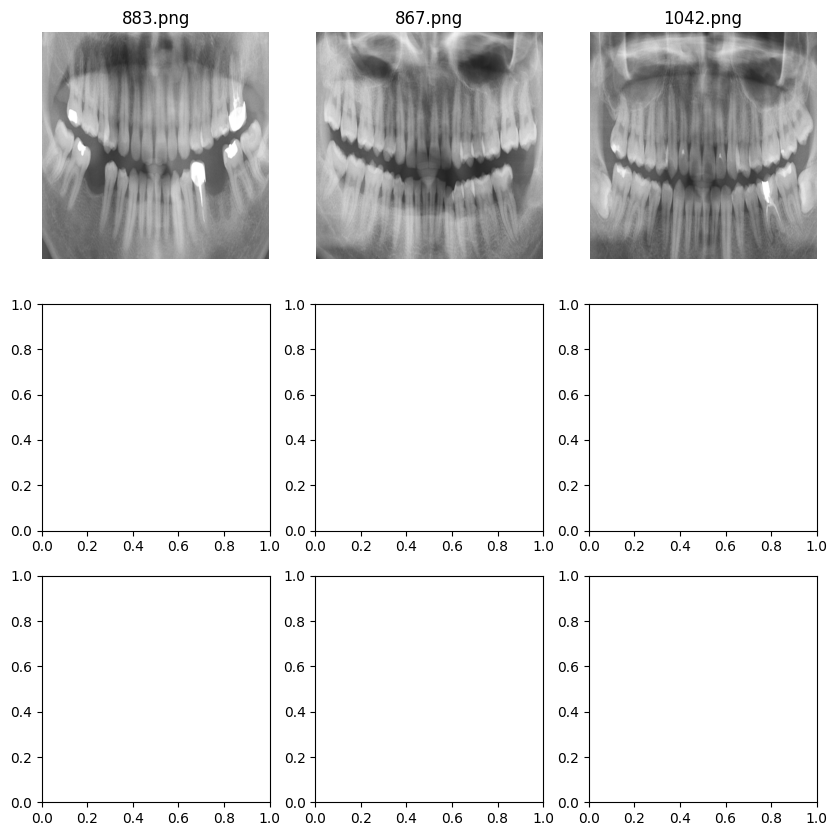

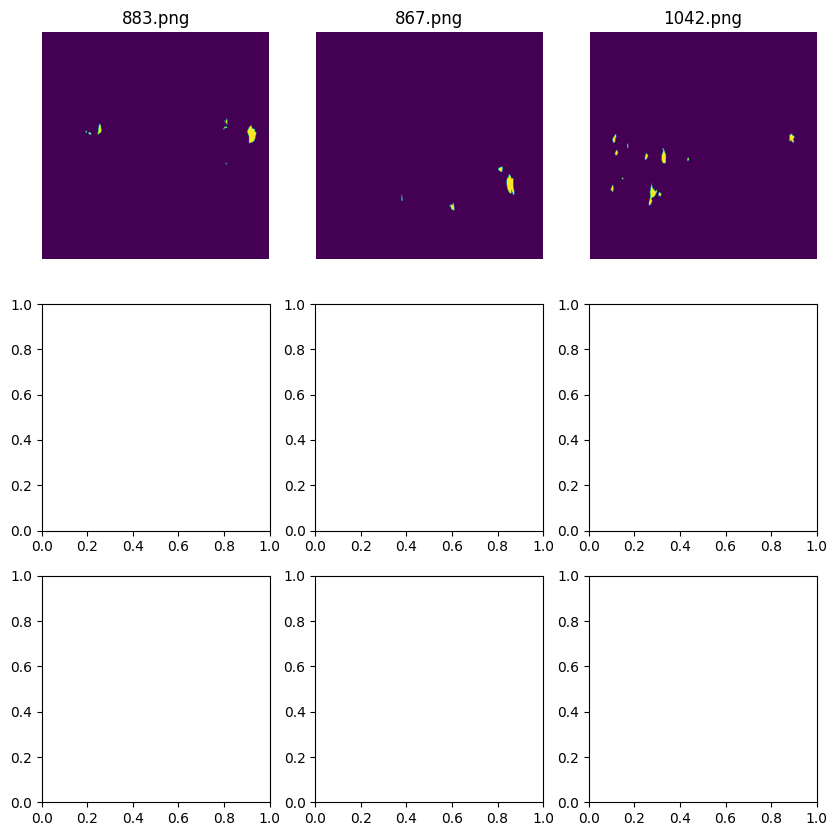

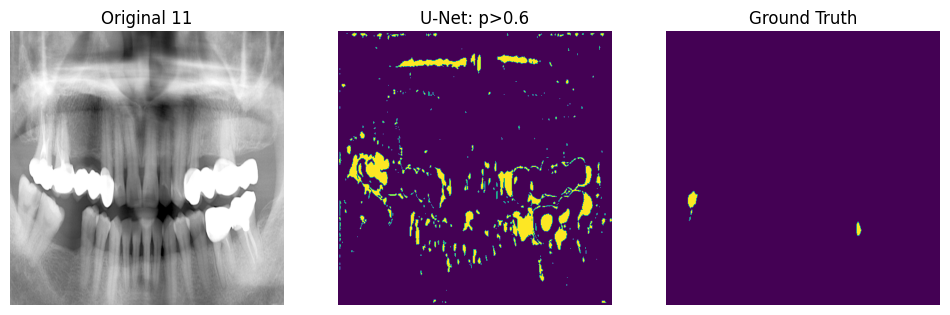

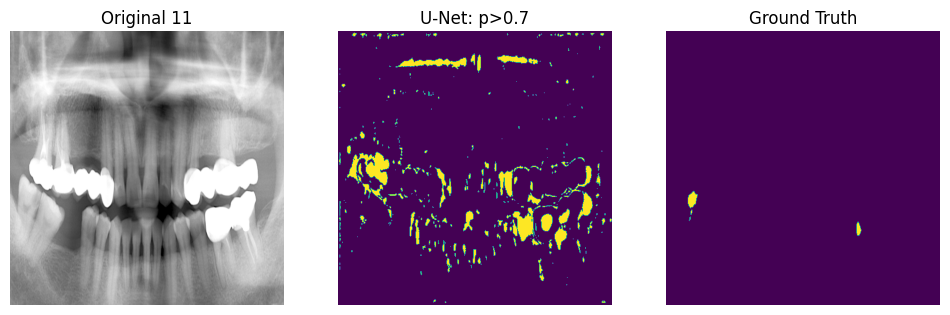

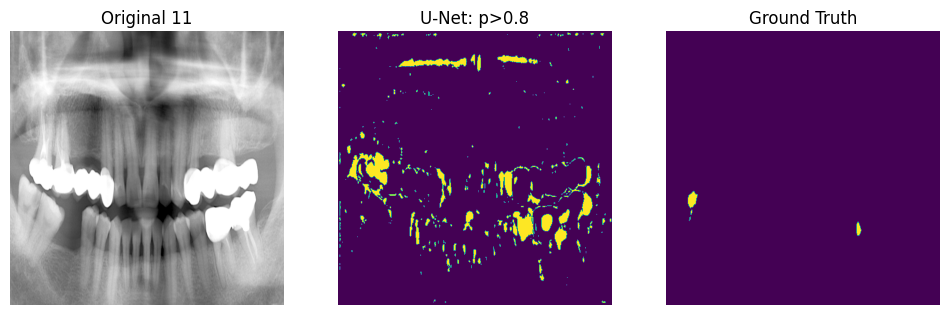

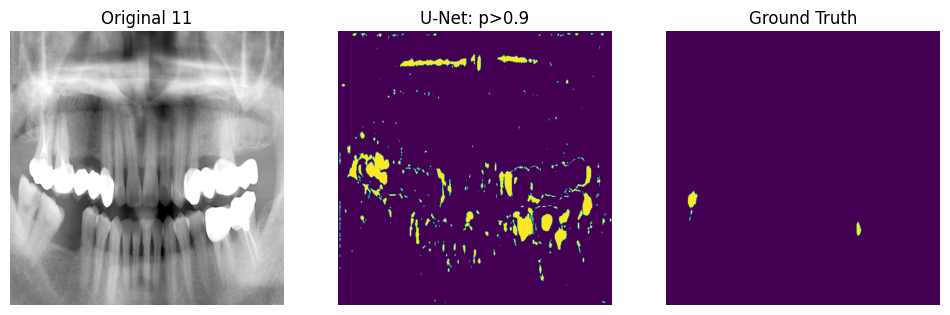

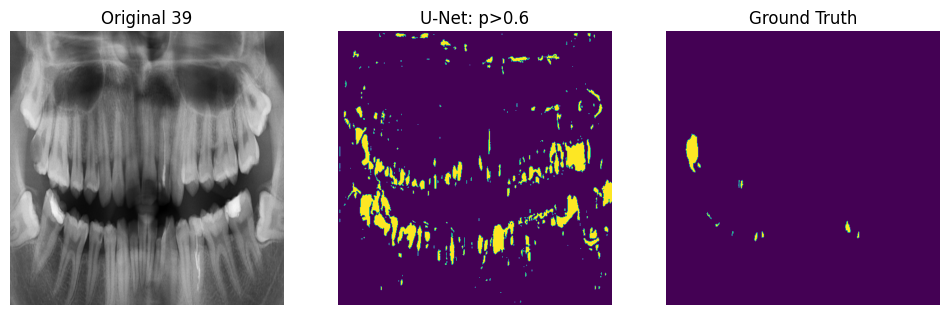

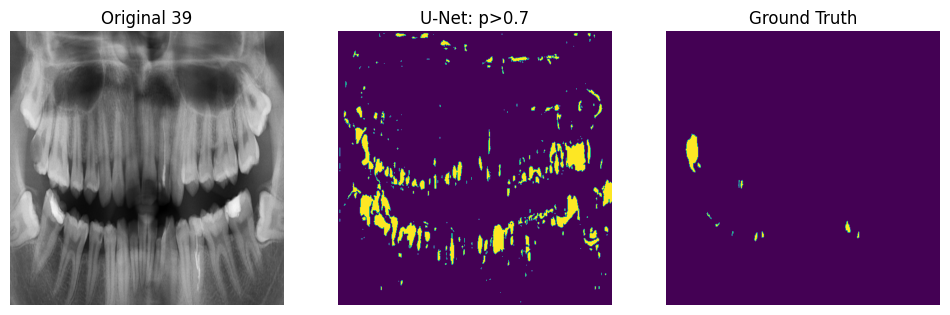

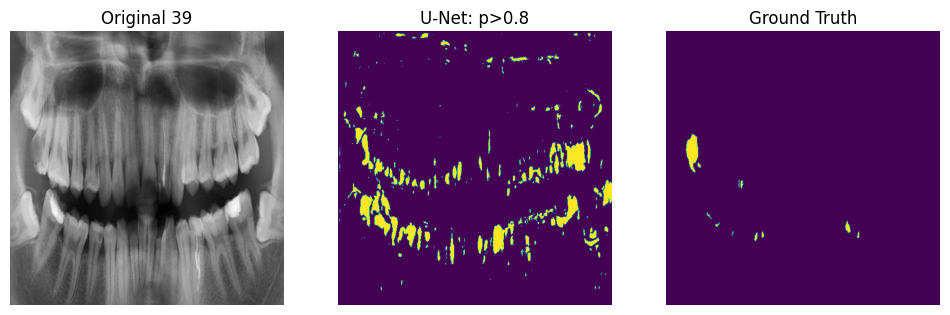

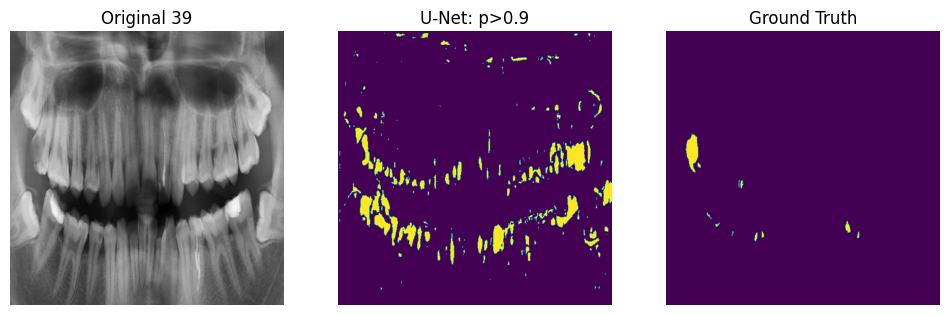

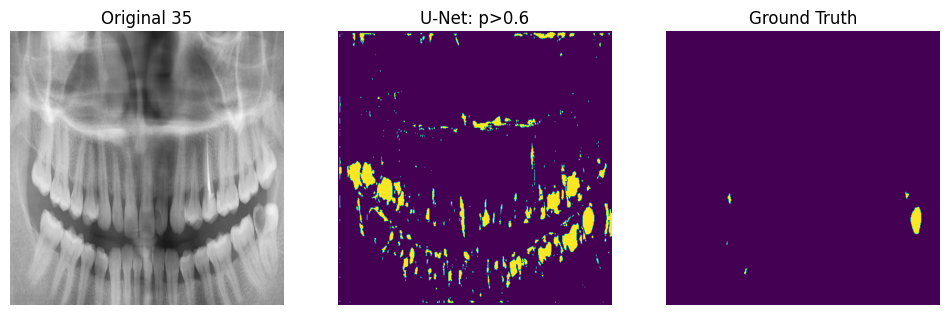

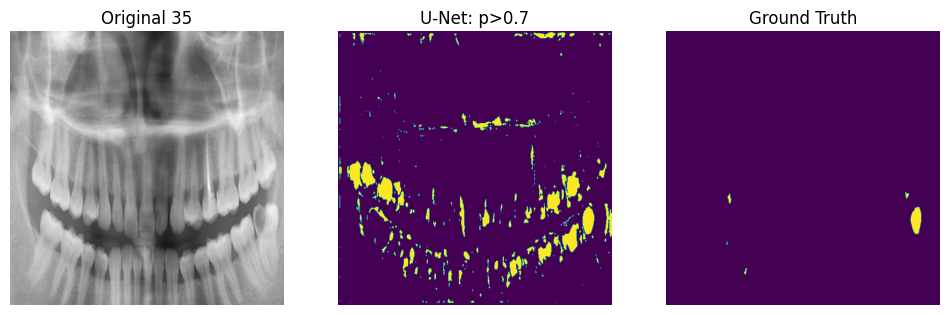

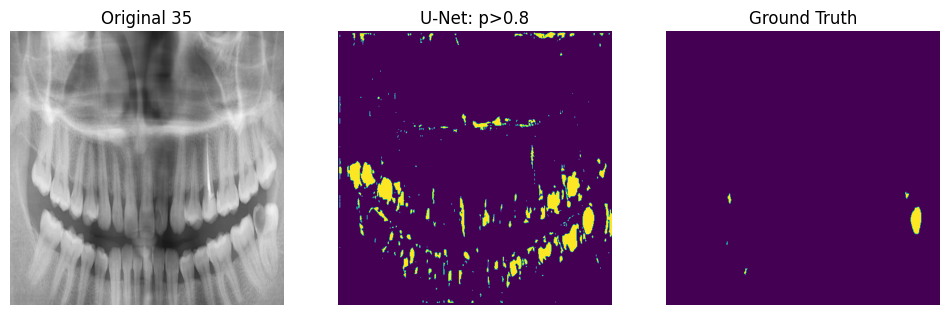

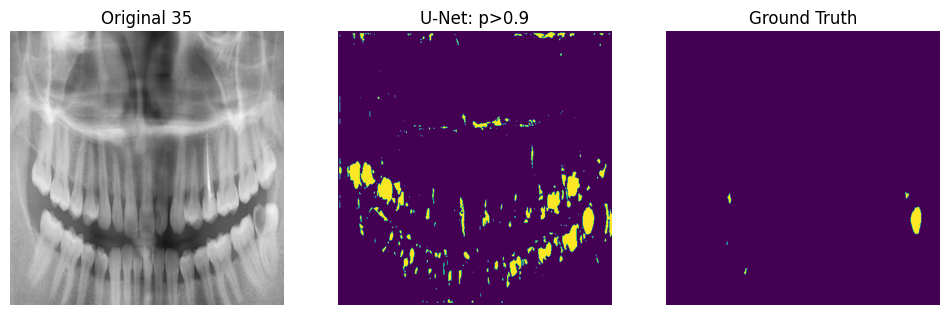

In [2]:


import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split


images_dir = 'archive/images_cut'
masks_dir = 'archive/labels_cut'

images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(images_listdir, size = 3, replace = False)

print(len(images_listdir))
print(len(masks_listdir))

image_size=512
input_image_size=(512,512)

def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

number=200



rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')


fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:number]):   
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        mask = read_image(f"{masks_dir}/{file}") 
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)    
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

images=np.array(IMAGES)[1:number+1]
masks=np.array(MASKS)[1:number+1]
print(images.shape,masks.shape)

images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)

print(len(images_train), len(masks_train))



def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




unet_result = unet_model.fit(
    images_train, masks_train, 
    validation_split = 0.2, batch_size = 8, epochs = 60)


def show_result(idx, og, unet, target, p):
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

unet_predict = unet_model.predict(images_test)

len(images_test)

r1,r2,r3,r4=0.6,0.7,0.8,0.9

unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx: 
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    print()

